In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_1minutes.csv")
data.drop(['Month'], axis =1, inplace= True)
#data.set_index("time", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['Unnamed: 0',  'green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3*60:, -1])
n_p = n_p + 365*24*3*60

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 60 + 1 : , :]
values = np.concatenate((a, b), axis=0)

data set for day categorization

In [6]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 60
train = values[n_train_hours - 225257:n_train_hours, :]
test = values[n_train_hours:n_train_hours + 55543, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(225257, 235) 225257 (225257,)
(225257, 47, 5) (225257,) (55543, 47, 5) (55543,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 225257 samples, validate on 55543 samples
Epoch 1/100
 - 60s - loss: 0.0238 - val_loss: 0.0209
Epoch 2/100
 - 59s - loss: 0.0164 - val_loss: 0.0195
Epoch 3/100
 - 84s - loss: 0.0162 - val_loss: 0.0148
Epoch 4/100
 - 83s - loss: 0.0152 - val_loss: 0.0195
Epoch 5/100
 - 84s - loss: 0.0146 - val_loss: 0.0184
Epoch 6/100
 - 83s - loss: 0.0152 - val_loss: 0.0140
Epoch 7/100
 - 84s - loss: 0.0144 - val_loss: 0.0151
Epoch 8/100
 - 83s - loss: 0.0148 - val_loss: 0.0151
Epoch 9/100
 - 84s - loss: 0.0144 - val_loss: 0.0143
Epoch 10/100
 - 83s - loss: 0.0143 - val_loss: 0.0147
Epoch 11/100
 - 84s - loss: 0.0143 - val_loss: 0.0142
Epoch 12/100
 - 83s - loss: 0.0141 - val_loss: 0.0141
Epoch 13/100
 - 83s - loss: 0.0142 - val_loss: 0.0143
Epoch 14/100
 - 83s - loss: 0.0145 - val_loss: 0.0138
Epoch 15/100
 - 83s - loss: 0.0142 - val_loss: 0.0144
Epoch 16/100
 - 84s - loss: 0.0144 - val_loss: 0.0148
Epoch 17/100
 - 83s - loss: 0.0141 - val_loss: 0.0141
Epoch 18/100
 - 84s - loss: 0.0143 - val

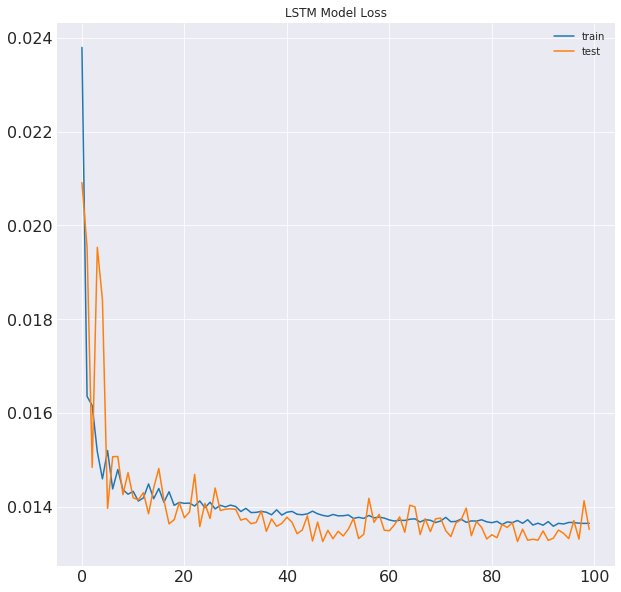

In [8]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [9]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9766256241077798
MAE:  13.622678
RMSE: 17.69121434332325
mean absolute error percentage:  7.386811077594757


In [10]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9762946946943242
MAE:  13.858207
RMSE: 17.982112049471986
mean absolute error percentage:  6.566692143678665


data set for time categorization

In [11]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 60
train = values[n_train_hours - 65700:n_train_hours, :]
test = values[n_train_hours:n_train_hours + 16393, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(65700, 235) 65700 (65700,)
(65700, 47, 5) (65700,) (16393, 47, 5) (16393,)


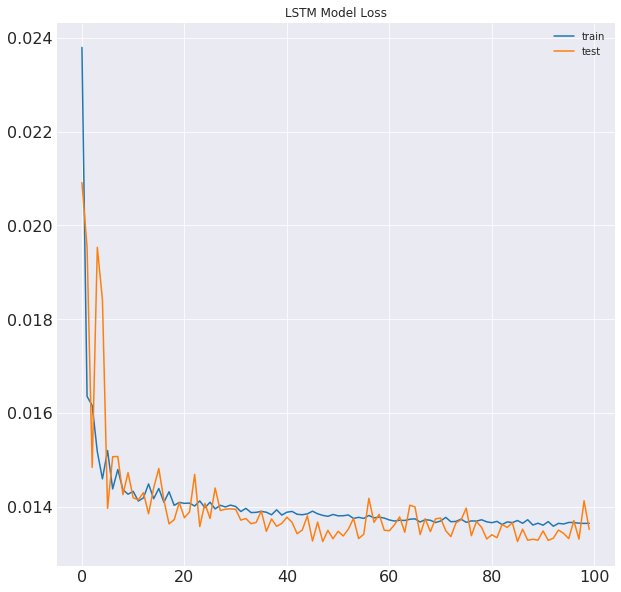

In [12]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [13]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9759237561033028
MAE:  13.309581
RMSE: 17.28332573287537
mean absolute error percentage:  8.242437988519669


In [14]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9778332870090332
MAE:  13.913975
RMSE: 18.049772325596226
mean absolute error percentage:  6.863237917423248
